<a href="https://colab.research.google.com/github/AlirezaPNouri/BERTEmbedding/blob/main/NYT_BERT_epoch40.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

date is 8/15/2021
Alireza P. Nouri Advisor: prof. M. Shahriar hossain contact: apashamoham@miners.utep.edu Implementing feature exrtaction by BERT model
This code runs on 100 NYTimes article, labled on two classes

In [1]:
# to check if the GPU is ready to use
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
# to tell pytorch that we are going to use GPU
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [3]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 5.1 MB/s 
     |████████████████████████████████| 895 kB 40.3 MB/s 
     |████████████████████████████████| 3.3 MB 38.8 MB/s 
     |████████████████████████████████| 636 kB 45.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=7da5b35ad47b6041123006406bc38e22221f7d5943d7c5df0f40262bec8c0ac9
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [5]:
# download the dataset as a zip file
import wget
import os
import requests
print('Downloading dataset...')

# The URL for the dataset zip file.
url = 'https://raw.githubusercontent.com/AlirezaPNouri/BERTEmbedding/main/small_dataset_NYT.csv'
res = requests.get(url, allow_redirects=True)
with open('small_dataset_NYT.csv','wb') as file:
    file.write(res.content)
print('Download is done!')

Download is done!


In [6]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("/content/small_dataset_NYT.csv",header=None,skiprows=1, names=['label', 'text'])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 20



,label,text
18,1,Amazon previously disclosed that 200 million p...
1,1,Amazon .com (AMZN) is everywhere. By disruptin...
16,1,Amazon has a growing role in the U.S. economy ...
12,1,Amazon became the second trillion-dollar compa...
11,0,The Amazon is critical to our efforts to avoid...
5,1,The company came under fire from Sen. Bernie S...
3,1,Amazon also engages several third-party contra...
7,1,concern rate rise come year investor may start...
9,1,Amazon s logistics infrastructure doesn t just...
6,0,Based on archaeological evidence from an excav...


In [7]:
# Get the lists of sentences and their labels.
sentences = df.text.values
labels = df.label.values

In [8]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Following the Cretaceous–Paleogene extinction event  the extinction of the dinosaurs and the wetter climate may have allowed the tropical rainforest to spread out across the continent. From 66 to 34 Mya  the rainforest extended as far south as 45°. Climate fluctuations during the last 34 million years have allowed savanna regions to expand into the tropics. During the Oligocene  for example  the rainforest spanned a relatively narrow band. It expanded again during the Middle Miocene  then retracted to a mostly inland formation at the last glacial maximum. However  the rainforest still managed to thrive during these glacial periods  allowing for the survival and evolution of a broad diversity of species. Aerial view of the Amazon rainforest During the mid-Eocene  it is believed that the drainage basin of the Amazon was split along the middle of the continent by the Purus Arch. Water on the eastern side flowed toward the Atlantic  while to the west water flowed toward the Pac

In [11]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 256,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Following the Cretaceous–Paleogene extinction event  the extinction of the dinosaurs and the wetter climate may have allowed the tropical rainforest to spread out across the continent. From 66 to 34 Mya  the rainforest extended as far south as 45°. Climate fluctuations during the last 34 million years have allowed savanna regions to expand into the tropics. During the Oligocene  for example  the rainforest spanned a relatively narrow band. It expanded again during the Middle Miocene  then retracted to a mostly inland formation at the last glacial maximum. However  the rainforest still managed to thrive during these glacial periods  allowing for the survival and evolution of a broad diversity of species. Aerial view of the Amazon rainforest During the mid-Eocene  it is believed that the drainage basin of the Amazon was split along the middle of the continent by the Purus Arch. Water on the eastern side flowed toward the Atlantic  while to the west water flowed toward the Paci

In [12]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  256


In [13]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)
print('train_inputs size is ',train_inputs.shape)
print('validation_inputs size is ',validation_inputs.shape)

train_inputs size is  torch.Size([18, 256])
validation_inputs size is  torch.Size([2, 256])


In [14]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct 

In [15]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 4
# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [16]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = True, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [17]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [18]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [69]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 40

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [70]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [71]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [72]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    embedding_layers = []
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        print(batch[2].shape)
        print(batch[1].shape)
        print(batch[0].shape)
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        # print(len(outputs))
        # print(outputs[0]) the loss
        # print(len(outputs[1])) the batches
        # print(len(outputs[2])) the embedding layers
        # import numpy as np
        # print(np.shape(outputs[2]))--->(13,)
        # print(np.shape(outputs[2][1])) --->torch.Size([32, 64, 768]) the embedding in the layer one
        # print(np.shape(outputs[2][2]))--->torch.Size([32, 64, 768]) the embedding in the layer two
        # print(len(outputs[2][3]))
        loss = outputs[0]
        
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        


======== Epoch 1 / 40 ========
Training...
torch.Size([4])
torch.Size([4, 256])
torch.Size([4, 256])
torch.Size([4])
torch.Size([4, 256])
torch.Size([4, 256])
torch.Size([4])
torch.Size([4, 256])
torch.Size([4, 256])
torch.Size([4])
torch.Size([4, 256])
torch.Size([4, 256])
torch.Size([2])
torch.Size([2, 256])
torch.Size([2, 256])

  Average training loss: 0.22
  Training epcoh took: 0:00:02

======== Epoch 2 / 40 ========
Training...
torch.Size([4])
torch.Size([4, 256])
torch.Size([4, 256])
torch.Size([4])
torch.Size([4, 256])
torch.Size([4, 256])
torch.Size([4])
torch.Size([4, 256])
torch.Size([4, 256])
torch.Size([4])
torch.Size([4, 256])
torch.Size([4, 256])
torch.Size([2])
torch.Size([2, 256])
torch.Size([2, 256])

  Average training loss: 0.15
  Training epcoh took: 0:00:02

======== Epoch 3 / 40 ========
Training...
torch.Size([4])
torch.Size([4, 256])
torch.Size([4, 256])
torch.Size([4])
torch.Size([4, 256])
torch.Size([4, 256])
torch.Size([4])
torch.Size([4, 256])
torch.Size(

In [73]:
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print(  "")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    #count = 0 # added by Ali
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        
        logits = outputs[0]
        # print(len(outputs))
        # print(np.shape(outputs[1])) # all embedding layers data
        # print(outputs[1][12]) # access to embedding vectors in layer 13
        #count +=1 added by Ali

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    #print(count)
print("")
print("Training complete!")


Running Validation...
  Accuracy: 1.00
  Validation took: 0:00:00

Training complete!


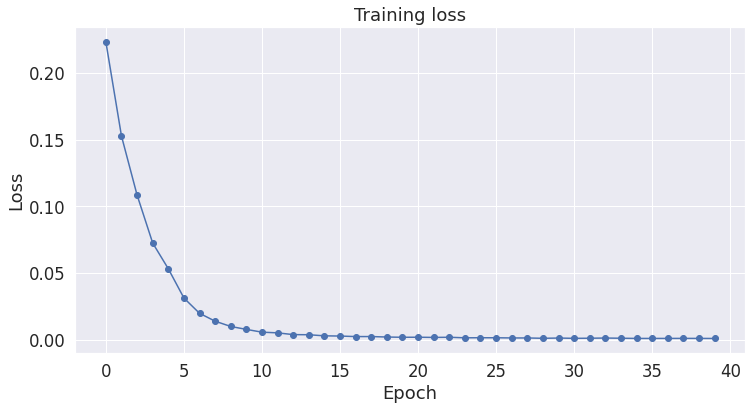

In [74]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [75]:
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
#the same as the maxlen we used in the encoder_plus function
MAX_LEN = max([len(sen) for sen in input_ids])
# Load the dataset into a pandas dataframe.
# df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.text.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 20



In [76]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  print('np.shape(outputs[0]) ', np.shape(outputs[0]))
  print('np.shape(outputs[1][0]) ', np.shape(outputs[1][0]))
  print('np.shape(outputs[1][1]) ', np.shape(outputs[1][1]))
  print('np.shape(outputs[1][12]) ', np.shape(outputs[1][12]))

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 20 test sentences...
np.shape(outputs[0])  torch.Size([20, 2])
np.shape(outputs[1][0])  torch.Size([20, 256, 768])
np.shape(outputs[1][1])  torch.Size([20, 256, 768])
np.shape(outputs[1][12])  torch.Size([20, 256, 768])
    DONE.


In [77]:
#print some data and their embeddings
print('np.shape(outputs[1][12]) ', np.shape(outputs[1][12]))
last_layer = outputs[1][12]
print('np.shape(last_layer[1])  ', np.shape(last_layer[1]))
print('np.shape(b_input_ids[1])  ', np.shape(b_input_ids[1]))
# print('doc 1 is: ',sentences[1])
# print('input ids for doc 1 is: ',b_input_ids[1])
# print('doc 1 after splitted by WordPiece is ', tokenizer.tokenize(sentences[1]))
# print('Embedding vector for doc 1 is: ', last_layer[1])
print('-----------------------------------------------')
print('doc 2 is: ',sentences[2])
print('input ids for doc 2 is: ',b_input_ids[2])
print('doc 2 after splitted by WordPiece is ', tokenizer.tokenize(sentences[2]))
print('Embedding vector for doc 2 is: ', last_layer[2])
print('-----------------------------------------------')
# print('doc 3 is: ',sentences[3])
# print('input ids for doc 3 is: ',b_input_ids[3])
# print('doc 3 after splitted by WordPiece is ', tokenizer.tokenize(sentences[3]))
# print('Embedding vector for doc 3 is: ', last_layer[3])
# print('-----------------------------------------------')
print('doc 4 is: ',sentences[4])
print('input ids for doc 4 is: ',b_input_ids[4])
print('doc 4 after splitted by WordPiece is ', tokenizer.tokenize(sentences[4]))
print('Embedding vector for doc 4 is: ', last_layer[4])

np.shape(outputs[1][12])  torch.Size([20, 256, 768])
np.shape(last_layer[1])   torch.Size([256, 768])
np.shape(b_input_ids[1])   torch.Size([256])
-----------------------------------------------
doc 2 is:  Amazon has disrupted traditional retail and accelerated the demise of struggling players. Without storefronts  the company’s overhead costs are significantly lower than other retailers. That gives Amazon the edge to undercut rivals on prices and operate on a thinner profit margin. Some economy watchers are nervous about Amazon’s deflationary impact. Ideally  low unemployment is accompanied by wage growth  which in turn fuels inflation as companies pass on the costs to consumers. That is the logic of the Phillips curve  but Amazon has disrupted it as well. Greater competition and lower prices can limit the ability of companies to pass on any wage increases to consumers. Those worries were echoed in the wake of the Whole Foods acquisition in 2017.4 Chicago Federal Reserve President Cha

768
768


In [78]:
#calculate the cosine similarities between words in a same doc or different ones
from sklearn.metrics.pairwise import cosine_similarity

print('result in layer 12')
# word_[company/forest]_doc#
amazon_company_2 = outputs[1][12][2][1]
company_company_2 = outputs[1][12][2][19]
retail_company_2 = outputs[1][12][2][5]
print(len(amazon_company_2))

amazon_forest_4 = outputs[1][12][4][13]
rainforest_forest_4 = outputs[1][12][4][14]
desert_forest_4 = outputs[1][12][4][28]
print(len(amazon_forest_4))
result = cosine_similarity([amazon_company_2.to('cpu').numpy()], [amazon_forest_4.to('cpu').numpy()])
print('[amazon] forest and [amazon] company in two different docs similarity is ', result)

result = cosine_similarity([company_company_2.to('cpu').numpy()], [retail_company_2.to('cpu').numpy()])
print('[retail]  and [company] in a same doc similarity is ', result)

result = cosine_similarity([rainforest_forest_4.to('cpu').numpy()], [amazon_forest_4.to('cpu').numpy()])
print('[rainforest]  and [amazon] forest in the same docs similarity is ', result)

result = cosine_similarity([desert_forest_4.to('cpu').numpy()], [amazon_company_2.to('cpu').numpy()])
print('[desert]  and [amazon] in a different docs similarity is ', result)
print('-------------------------------------')
print('result in layer 1')
amazon_company_2 = outputs[1][1][2][1]
company_company_2 = outputs[1][1][2][19]
retail_company_2 = outputs[1][1][2][5]
amazon_forest_4 = outputs[1][1][4][13]
rainforest_forest_4 = outputs[1][1][4][14]
desert_forest_4 = outputs[1][1][4][28]

result = cosine_similarity([amazon_company_2.to('cpu').numpy()], [amazon_forest_4.to('cpu').numpy()])
print('[amazon] forest and [amazon] company in two different docs similarity is ', result)

result = cosine_similarity([company_company_2.to('cpu').numpy()], [retail_company_2.to('cpu').numpy()])
print('[retail]  and [company] in a same doc similarity is ', result)

result = cosine_similarity([rainforest_forest_4.to('cpu').numpy()], [amazon_forest_4.to('cpu').numpy()])
print('[rainforest]  and [amazon] forest in the same docs similarity is ', result)

result = cosine_similarity([desert_forest_4.to('cpu').numpy()], [amazon_company_2.to('cpu').numpy()])
print('[desert]  and [amazon] in a different docs similarity is ', result)
print('-------------------------------------')
print('result in layer 0')
# word_[company/forest]_doc#
amazon_company_2 = outputs[1][0][2][1]
company_company_2 = outputs[1][0][2][19]
retail_company_2 = outputs[1][0][2][5]
print(len(amazon_company_2))

amazon_forest_4 = outputs[1][0][4][13]
rainforest_forest_4 = outputs[1][0][4][14]
desert_forest_4 = outputs[1][0][4][28]
print(len(amazon_forest_4))
result = cosine_similarity([amazon_company_2.to('cpu').numpy()], [amazon_forest_4.to('cpu').numpy()])
print('[amazon] forest and [amazon] company in two different docs similarity is ', result)

result = cosine_similarity([company_company_2.to('cpu').numpy()], [retail_company_2.to('cpu').numpy()])
print('[retail]  and [company] in a same doc similarity is ', result)

result = cosine_similarity([rainforest_forest_4.to('cpu').numpy()], [amazon_forest_4.to('cpu').numpy()])
print('[rainforest]  and [amazon] forest in the same docs similarity is ', result)

result = cosine_similarity([desert_forest_4.to('cpu').numpy()], [amazon_company_2.to('cpu').numpy()])
print('[desert]  and [amazon] in a different docs similarity is ', result)


result in layer 12
768
768
[amazon] forest and [amazon] company in two different docs similarity is  [[0.06944938]]
[retail]  and [company] in a same doc similarity is  [[0.74640775]]
[rainforest]  and [amazon] forest in the same docs similarity is  [[0.79623616]]
[desert]  and [amazon] in a different docs similarity is  [[-0.08712007]]
-------------------------------------
result in layer 1
[amazon] forest and [amazon] company in two different docs similarity is  [[0.86345685]]
[retail]  and [company] in a same doc similarity is  [[0.17593697]]
[rainforest]  and [amazon] forest in the same docs similarity is  [[0.32412595]]
[desert]  and [amazon] in a different docs similarity is  [[0.16314918]]
-------------------------------------
result in layer 0
768
768
[amazon] forest and [amazon] company in two different docs similarity is  [[0.9139333]]
[retail]  and [company] in a same doc similarity is  [[0.08698446]]
[rainforest]  and [amazon] forest in the same docs similarity is  [[0.1848

[amazon] forest and [amazon] company in two different docs similarity is  [0.9139333, 0.86345685, 0.76361114, 0.66227204, 0.5584514, 0.5343182, 0.4883322, 0.4299878, 0.34008682, 0.31219304, 0.29801452, 0.17911005, 0.06944938]


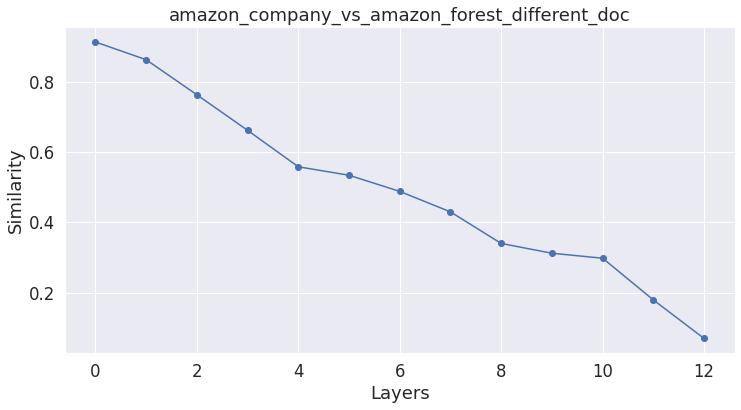

[retail]  and [company] in a same doc similarity is  [0.08698446, 0.17593697, 0.20748268, 0.23872222, 0.2908972, 0.39046192, 0.37037778, 0.35931158, 0.40448454, 0.43185532, 0.5828811, 0.70090866, 0.74640775]


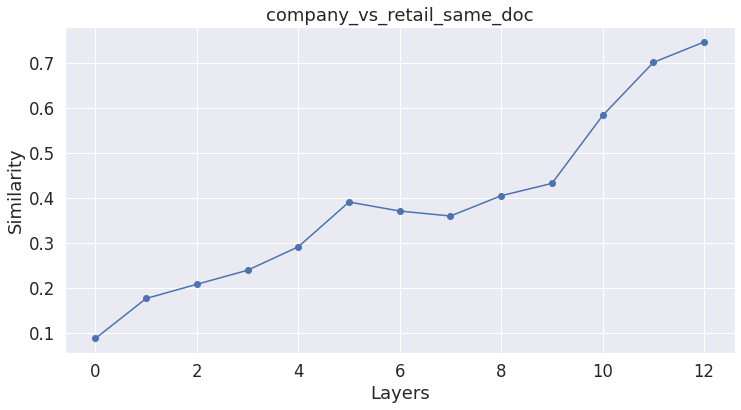

[rainforest]  and [amazon] forest in the same docs similarity is  [0.18483603, 0.32412595, 0.35723883, 0.3411819, 0.39522147, 0.52598333, 0.61885893, 0.6782049, 0.68099475, 0.6848771, 0.7362256, 0.7587559, 0.79623616]


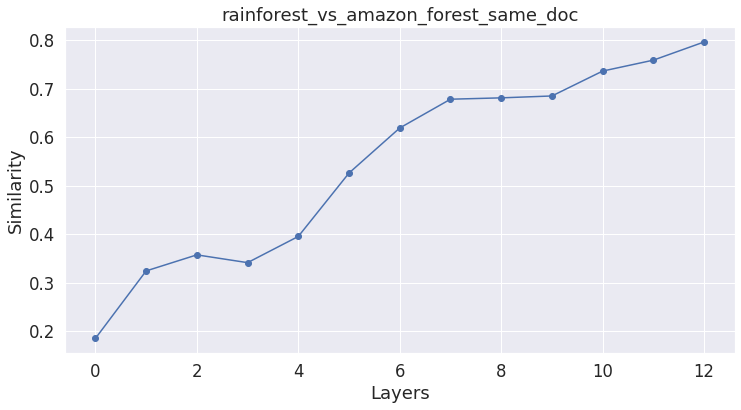

[desert]  and [amazon] in a different docs similarity is  [0.09826084, 0.16314918, 0.120271295, 0.16297604, 0.16532567, 0.20714238, 0.23526217, 0.18953553, 0.15401542, 0.080816, 0.10253948, -0.0033569243, -0.08712007]


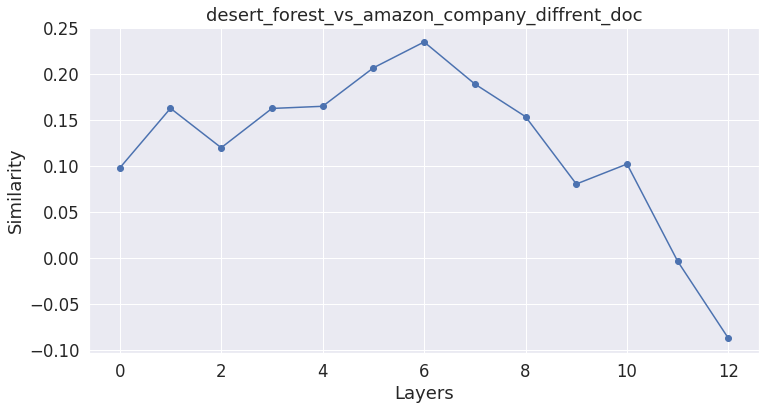

In [79]:
amazon_company_vs_amazon_forest_different_doc = list()
company_vs_retail_same_doc = list()
rainforest_vs_amazon_forest_same_doc = list()
desert_forest_vs_amazon_company_diffrent_doc = list()
for layers in range(0,13):
  amazon_company_2 = outputs[1][layers][2][1]
  company_company_2 = outputs[1][layers][2][19]
  retail_company_2 = outputs[1][layers][2][5]

  amazon_forest_4 = outputs[1][layers][4][13]
  rainforest_forest_4 = outputs[1][layers][4][14]
  desert_forest_4 = outputs[1][layers][4][28]

  amazon_company_vs_amazon_forest_different_doc.append(cosine_similarity([amazon_company_2.to('cpu').numpy()], [amazon_forest_4.to('cpu').numpy()])[0][0])
  company_vs_retail_same_doc.append(cosine_similarity([company_company_2.to('cpu').numpy()], [retail_company_2.to('cpu').numpy()])[0][0])
  rainforest_vs_amazon_forest_same_doc.append(cosine_similarity([rainforest_forest_4.to('cpu').numpy()], [amazon_forest_4.to('cpu').numpy()])[0][0])
  desert_forest_vs_amazon_company_diffrent_doc.append(cosine_similarity([desert_forest_4.to('cpu').numpy()], [amazon_company_2.to('cpu').numpy()])[0][0])


print('[amazon] forest and [amazon] company in two different docs similarity is ', amazon_company_vs_amazon_forest_different_doc)
# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(amazon_company_vs_amazon_forest_different_doc, 'b-o')

# Label the plot.
plt.title("amazon_company_vs_amazon_forest_different_doc")
plt.xlabel("Layers")
plt.ylabel("Similarity")

plt.show()
print('[retail]  and [company] in a same doc similarity is ', company_vs_retail_same_doc)
plt.plot(company_vs_retail_same_doc, 'b-o')

# Label the plot.
plt.title("company_vs_retail_same_doc")
plt.xlabel("Layers")
plt.ylabel("Similarity")

plt.show()
print('[rainforest]  and [amazon] forest in the same docs similarity is ', rainforest_vs_amazon_forest_same_doc)
plt.plot(rainforest_vs_amazon_forest_same_doc, 'b-o')

# Label the plot.
plt.title("rainforest_vs_amazon_forest_same_doc")
plt.xlabel("Layers")
plt.ylabel("Similarity")

plt.show()
print('[desert]  and [amazon] in a different docs similarity is ', desert_forest_vs_amazon_company_diffrent_doc)  
plt.plot(desert_forest_vs_amazon_company_diffrent_doc, 'b-o')

# Label the plot.
plt.title("desert_forest_vs_amazon_company_diffrent_doc")
plt.xlabel("Layers")
plt.ylabel("Similarity")
plt.show()

In [40]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 10 of 20 (50.00%)


In [43]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)
  

Calculating Matthews Corr. Coef. for each batch...
[1.0]


In [44]:
matthews_set

[1.0]

In [45]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 1.000
